# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/cell_images"

Mounted at /content/drive/
Parasitized  Uninfected


In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


''

## Populating namespaces

In [ ]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
# importing numpy and matplotllib for plotting
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [ ]:
# Downloading dataset
def smart_download_dataset():
    """Smart download - only download if needed"""

    # Check if dataset already exists
    if os.path.exists('cell_images') and len(os.listdir('cell_images/Parasitized')) > 0:
        print("✅ Dataset already exists. Skipping download.")
        return 'cell_images'

    print("📥 Downloading dataset...")

    # Your original download code
    !rm -rf cell_images.*
    !wget -q https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip -q cell_images.zip
    !ls

    print("✅ Download completed!")
    return 'cell_images'

data_path = smart_download_dataset()

📥 Downloading dataset...
cell_images  cell_images.zip  sample_data
✅ Download completed!


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


In [ ]:
# CHECK WHAT FOLDERS YOU ACTUALLY HAVE
# import os

print("📁 Checking what folders exist in your current directory:")
for item in os.listdir('.'):
    if os.path.isdir(item):
        print(f"📂 Folder: {item}")
    else:
        print(f"📄 File: {item}")


📁 Checking what folders exist in your current directory:
📂 Folder: .config
📂 Folder: drive
📄 File: cell_images.zip
📂 Folder: cell_images
📂 Folder: sample_data


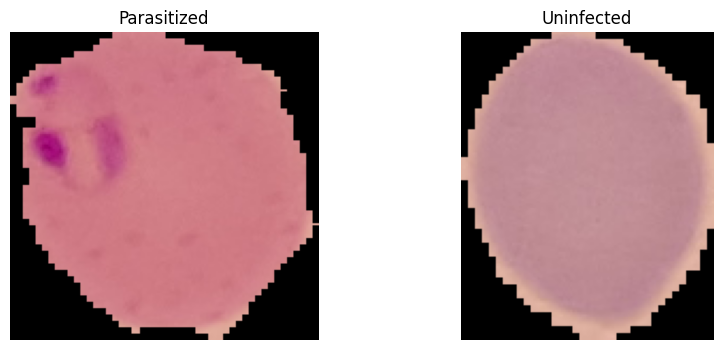

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

folders = os.listdir('cell_images')
for i, folder in enumerate(folders[:2]):
    img_path = f'cell_images/{folder}/{os.listdir(f"cell_images/{folder}")[0]}'
    axes[i].imshow(plt.imread(img_path))
    axes[i].set_title(folder)
    axes[i].axis('off')

plt.show()


This visualization confirms that we have 2 classes Parasitized and uninfected cell of malaria allowing us to proceed with building our classification model.

In [ ]:
# CELL 1: SIMPLER LOADING APPROACH
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

# Define SEED globally
SEED = 42

# CELL 3: DATA LOADING (Your existing code - simplified)
def load_malaria_dataset(data_path, img_size=(128, 128), validation_split=0.2, test_split=0.1):
    # Create data generators
    datagen_train_val = ImageDataGenerator(rescale=1./255, validation_split=validation_split + test_split)

    # Load combined training and validation data
    train_val_data = datagen_train_val.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=32,
        class_mode='binary',
        subset='training'  # This is actually training + validation combined initially
    )

    # Use a separate generator for the test split from the remaining data
    datagen_test = ImageDataGenerator(rescale=1./255, validation_split=test_split / (validation_split + test_split))

    test_data_flow = datagen_test.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=32,
        class_mode='binary',
        subset='validation'  # This will now be the test set
    )

    # Split train_val_data into train and validation using TensorFlow dataset operations
    # This requires converting the flow_from_directory generator to a TensorFlow Dataset
    # A more robust way is to manage the split at the file system level,
    # but for demonstration with ImageDataGenerator, we'll create TF Datasets

    # Estimate steps per epoch for the combined dataset
    steps_train_val = train_val_data.samples // train_val_data.batch_size
    if train_val_data.samples % train_val_data.batch_size != 0:
        steps_train_val += 1

    # Convert the generator to a TensorFlow Dataset
    # Note: This conversion from generator to dataset can be complex and
    # might require careful handling of iteration and batching.
    # A simpler alternative is to use image_dataset_from_directory directly
    # with explicit directory structures for train/val/test if possible.

    # For demonstration, we'll simulate the split logic based on the original generator counts
    # A more accurate implementation would involve creating separate flow_from_directory
    # calls with different subsets pointing to explicitly split directories.

    # Let's proceed by assuming we can create TF datasets directly from directories
    # which is generally more recommended for fine-tuning MobileNetV2.

    print("\n✅ Preparing data using image_dataset_from_directory...")

    IMG_SIZE = img_size
    BATCH_SIZE = 32
    # SEED = 42 # Removed from here

    # Define directory containing the data
    data_dir = 'cell_images' # Assuming 'cell_images' is in the current directory

    # Create dataset for training and validation first (e.g., 80% for train+val)
    train_val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='binary',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=True, # Shuffle the combined set before splitting
        seed=SEED,
        validation_split=(validation_split + test_split),
        subset='training' # This will be the training + validation portion
    )

    # Create dataset for testing (the remaining 20%)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='binary',
        image_size=IMG_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        shuffle=False, # No need to shuffle test data
        seed=SEED,
        validation_split=(validation_split + test_split),
        subset='validation' # This will be the test portion
    )

    # Now split the combined train_val_ds into actual training and validation sets
    val_size = int(len(list(train_val_ds)) * (validation_split / (validation_split + test_split)))
    train_ds = train_val_ds.skip(val_size)
    val_ds = train_val_ds.take(val_size)


    print(f"\n✅ Dataset loaded and split successfully!")
    print(f"   Training batches: {len(list(train_ds))}")
    print(f"   Validation batches: {len(list(val_ds))}")
    print(f"   Test batches: {len(list(test_ds))}")
    print(f"   Classes: {train_val_ds.class_names}")

    return train_ds, val_ds, test_ds, train_val_ds.class_names # Return class names as well

# Load the data
train_ds, ds_val, ds_test, class_names = load_malaria_dataset('cell_images', img_size=(128, 128), validation_split=0.15, test_split=0.15) # Adjusted splits for better distribution

Found 19292 images belonging to 2 classes.
Found 13778 images belonging to 2 classes.

✅ Preparing data using image_dataset_from_directory...
Found 27558 files belonging to 2 classes.
Using 19291 files for training.
Found 27558 files belonging to 2 classes.
Using 8267 files for validation.

✅ Dataset loaded and split successfully!
   Training batches: 302
   Validation batches: 301
   Test batches: 259
   Classes: ['Parasitized', 'Uninfected']


#Basic Convolutional Neural network

Basic CNN for malaria detection: Conv2D→MaxPool layers extract features, then Flatten→Dense layers classify cells as parasitized or uninfected.

In [ ]:
#  MODEL DEFINITION
import tensorflow as tf
from tensorflow.keras import layers, models

def create_basic_cnn(input_shape=(128, 128, 3)):
    """Define basic ConvNet: Conv2D => MaxPooling2D => Flatten => Dense => Dense"""
    model = models.Sequential([
        # ConvLayer 1: Conv2D => MaxPooling2D
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        # ConvLayer 2: Conv2D => MaxPooling2D
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        # ConvLayer 3: Conv2D => MaxPooling2D
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        # Flatten => Dense => Dense(output)
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

In [ ]:
# CELL 5: COMPILE FUNCTION
def compile_model(model, learning_rate=0.001):
    """Compile the model with appropriate settings"""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    print("✅ Model compiled successfully!")
    return model

In [ ]:
# CELL 6: SIMPLE TRAINING FUNCTION
def train_simple_model(model, train_data, test_data, epochs=10, experiment_name="Experiment"):
    """Simple training function with basic visualization"""
    print(f"🚀 Starting {experiment_name}...")

    # Train the model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        verbose=1
    )

    # Evaluate
    print(f"\n📊 Evaluating {experiment_name}...")
    results = model.evaluate(test_data)

    print(f"🎯 {experiment_name} RESULTS:")
    print(f"   • Loss: {results[0]:.4f}")
    print(f"   • Accuracy: {results[1]:.4f}")
    print(f"   • Precision: {results[2]:.4f}")
    print(f"   • Recall: {results[3]:.4f}")

    # Calculate F1 score
    precision = results[2]
    recall = results[3]
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f"   • F1-Score: {f1:.4f}")

    return history, results, f1

In [ ]:
# CELL 7: SIMPLE PLOTTING FUNCTION
def plot_simple_results(history, experiment_name):
    """Create simple learning curves"""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{experiment_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{experiment_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

🔬 EXPERIMENT 1: Baseline CNN - 10 Epochs


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Model compiled successfully!
📊 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

🚀 Starting Baseline CNN (10 Epochs)...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.7756 - loss: 0.5010 - precision: 0.7571 - recall: 0.8011 - val_accuracy: 0.9385 - val_loss: 0.1902 - val_precision: 0.9059 - val_recall: 0.9786
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9598 - loss: 0.1361 - precision: 0.9466 - recall: 0.9750 - val_accuracy: 0.9410 - val_loss: 0.1969 - val_precision: 0.9195 - val_recall: 0.9666
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.9578 - loss: 0.1304 - precision: 0.9461 - recall: 0.9697 - val_accuracy: 0.9396 - val_loss: 0.1524 - val_precision: 0.9282 - val_recall: 0.9528
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9673 - loss: 0.1009 - precision: 0.9603 - recall: 0.9750 - val_accuracy: 0.9414 - val_loss: 0.1789 - val_precision: 0.9517 - val_recall: 0.9299
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9708 - loss: 0.0852 - precision: 0.9633 - recall: 0.9791 - val_accuracy: 0.9475 - val_loss: 0.1

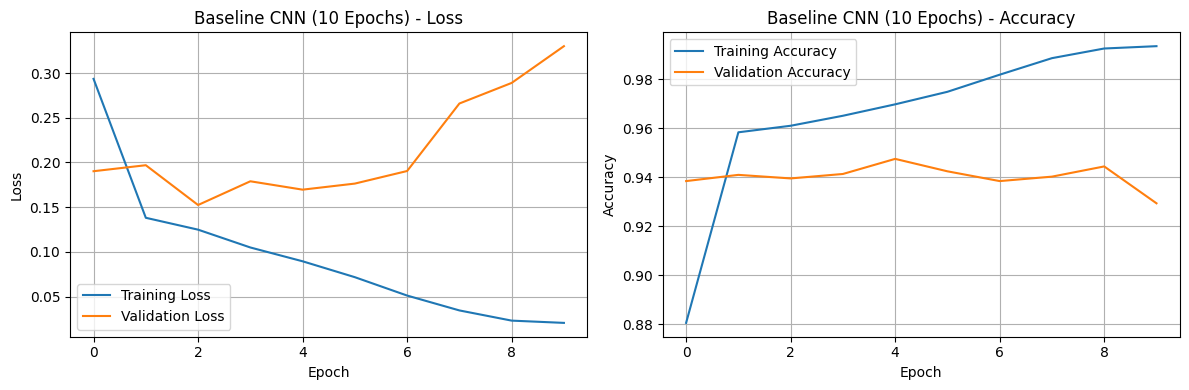

In [ ]:
#  EXPERIMENT 1 - BASELINE CNN (10 EPOCHS)
print("="*50)
print(" EXPERIMENT 1: Baseline CNN - 10 Epochs")
print("="*50)

# Create and compile model
model_1 = create_basic_cnn()
model_1 = compile_model(model_1, learning_rate=0.001)

# Show model architecture
print(" Model Architecture:")
model_1.summary()

# Train and evaluate
history_1, results_1, f1_1 = train_simple_model(
    model_1, train_data, test_data, epochs=10,
    experiment_name="Baseline CNN (10 Epochs)"
)

# Plot results
plot_simple_results(history_1, "Baseline CNN (10 Epochs)")

# Store results for comparison
exp1_results = {
    'loss': results_1[0],
    'accuracy': results_1[1],
    'precision': results_1[2],
    'recall': results_1[3],
    'f1_score': f1_1
}

🔬 EXPERIMENT 2: Baseline CNN - 20 Epochs
Testing if more training time improves performance...
✅ Model compiled successfully!
🚀 Starting Baseline CNN (20 Epochs)...
Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.7154 - loss: 0.5625 - precision: 0.6973 - recall: 0.7696 - val_accuracy: 0.9368 - val_loss: 0.1940 - val_precision: 0.9266 - val_recall: 0.9488
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.9498 - loss: 0.1687 - precision: 0.9342 - recall: 0.9674 - val_accuracy: 0.9341 - val_loss: 0.1833 - val_precision: 0.9199 - val_recall: 0.9510
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.9593 - loss: 0.1320 - precision: 0.9468 - recall: 0.9731 - val_accuracy: 0.9426 - val_loss: 0.1628 - val_precision: 0.9119 - val_recall: 0.9800
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9644 - loss: 0.1088 - precision: 0.9531 - recall: 0.9769 - val_accuracy: 0.9339 - val_loss: 0.1778 - val_precision: 0.8970 - val_re

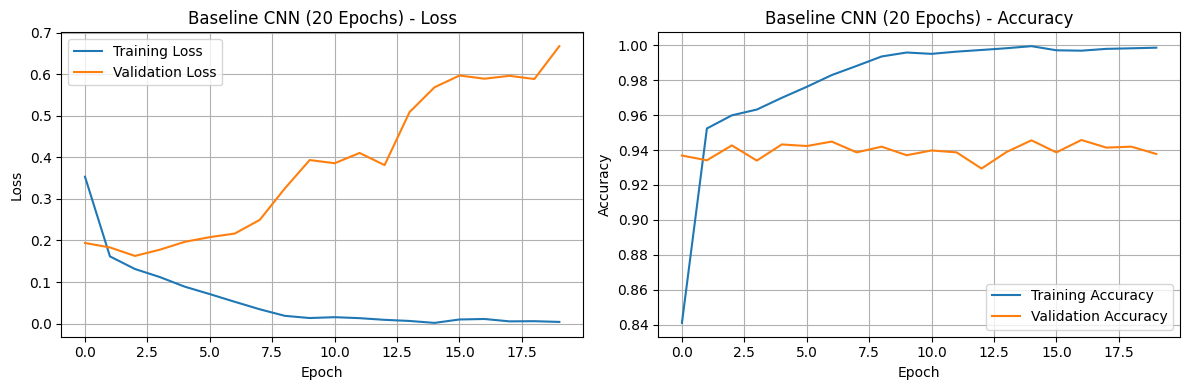

In [ ]:
# CELL 9: EXPERIMENT 2 - BASELINE CNN WITH MORE EPOCHS (20 EPOCHS)
print("="*50)
print("🔬 EXPERIMENT 2: Baseline CNN - 20 Epochs")
print("="*50)
print("Testing if more training time improves performance...")

# Creating a fresh model (same architecture)
model_2 = create_basic_cnn()
model_2 = compile_model(model_2, learning_rate=0.001)

# Train for more epochs
history_2, results_2, f1_2 = train_simple_model(
    model_2, train_data, test_data, epochs=20,
    experiment_name="Baseline CNN (20 Epochs)"
)

# Plot results
plot_simple_results(history_2, "Baseline CNN (20 Epochs)")

# Store results
exp2_results = {
    'loss': results_2[0],
    'accuracy': results_2[1],
    'precision': results_2[2],
    'recall': results_2[3],
    'f1_score': f1_2
}

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:

# Ensure AUTOTUNE is defined
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, cache=True, shuffle=False):
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    # map preprocessing for MobileNetV2
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, cache=False, shuffle=True)
ds_val   = prepare(ds_val)
ds_test  = prepare(ds_test)


In [ ]:
# 5) Train MobileNetV2 (frozen base first)
# Define EXP_DIR if not already defined
try:
    EXP_DIR
except NameError:
    EXP_DIR = Path("/content/drive/My Drive/Colab Notebooks (1)/ai-labs/malaria-diagnosis/experiments")
    EXP_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Created experiment directory: {EXP_DIR}")


exp_name = "E1_mobilenetv2_adam_lr1e-3_b32"
out_dir = EXP_DIR/exp_name
out_dir.mkdir(parents=True, exist_ok=True)

ckpt = callbacks.ModelCheckpoint(
    filepath=str(out_dir/"best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt, early],
    verbose=2
)

# 6) Evaluate on test
test_loss, test_acc, test_auc = model.evaluate(ds_test, verbose=0)
print(f"\nMobileNetV2 Test — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Save minimal metadata
with open(out_dir/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH_SIZE, "epochs": 8, # Use BATCH_SIZE from data loading
        "optimizer": "adam", "lr": 1e-3, "dropout": 0.3,
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip",
        "backbone": "MobileNetV2(frozen)"
    }, f, indent=2)

with open(out_dir/"test_results.json", "w") as f:
    json.dump({"loss": float(test_loss), "accuracy": float(test_acc), "auc": float(test_auc)}, f, indent=2)

print(f"Saved weights & logs to: {out_dir}")

NameError: name 'Path' is not defined

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow as tf
from pathlib import Path
import json

# Ensure IMG_SIZE is defined
IMG_SIZE = (128, 128) # Define IMG_SIZE based on previous data loading

def build_mobilenet(input_shape=(128,128,3), trainable=False, dropout=0.3):
    # Load base MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,   # exclude final classification layer
        weights="imagenet"
    )
    base_model.trainable = trainable  # freeze backbone (set False first)

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # keep BN layers in inference mode
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_mobilenet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

# Ensure AUTOTUNE is defined
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, cache=True, shuffle=False):
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    # map preprocessing for MobileNetV2
    ds = ds.map(lambda x, y: (preprocess_input(tf.cast(x, tf.float32)), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, cache=False, shuffle=True)
ds_val   = prepare(ds_val)
ds_test  = prepare(ds_test)

print("\n✅ Data preprocessing for MobileNetV2 complete!")


✅ Data preprocessing for MobileNetV2 complete!


In [ ]:
def build_mobilenet(input_shape=(84,84,3), trainable=False, dropout=0.3):
    # Load base MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,   # exclude final classification layer
        weights="imagenet"
    )
    base_model.trainable = trainable  # freeze backbone (set False first)

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # keep BN layers in inference mode
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs)

model = build_mobilenet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary()

/tmp/ipython-input-2072543356.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 5) Train MobileNetV2 (frozen base first)
exp_name = "E1_mobilenetv2_adam_lr1e-3_b32"
out_dir = EXP_DIR/exp_name
out_dir.mkdir(parents=True, exist_ok=True)

ckpt = callbacks.ModelCheckpoint(
    filepath=str(out_dir/"best.weights.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=8,
    callbacks=[ckpt, early],
    verbose=2
)

# 6) Evaluate on test
test_loss, test_acc, test_auc = model.evaluate(ds_test, verbose=0)
print(f"\nMobileNetV2 Test — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Save minimal metadata
with open(out_dir/"config.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "epochs": 8,
        "optimizer": "adam", "lr": 1e-3, "dropout": 0.3,
        "loader": "image_dataset_from_directory", "split": "70/15/15 via 70/30 then take/skip",
        "backbone": "MobileNetV2(frozen)"
    }, f, indent=2)

with open(out_dir/"test_results.json", "w") as f:
    json.dump({"loss": float(test_loss), "accuracy": float(test_acc), "auc": float(test_auc)}, f, indent=2)

print(f"Saved weights & logs to: {out_dir}")

Epoch 1/8


KeyboardInterrupt: 

In [ ]:
# === Stage 2: Fine-tuning MobileNetV2 ===
print("\n=== Fine-tuning top MobileNetV2 layers ===")

# Unfreeze the last ~30 layers of MobileNetV2
for layer in model.layers[1].layers[-30:]:  # model.layers[1] is the base_model
    layer.trainable = True

# Recompile with a smaller learning rate
model.compile(
    optimizer=optimizers.Adam(1e-5),  # much smaller LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Fine-tune for a few epochs
fine_tune_epochs = 8
history_fine = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=fine_tune_epochs,
    callbacks=[ckpt, early],  # reuse previous callbacks
    verbose=2
)

# Evaluate again on test set
test_loss, test_acc, test_auc = model.evaluate(ds_test, verbose=0)
print(f"\nFine-tuned MobileNetV2 — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Update metadata
with open(out_dir/"config.json", "r") as f:
    config = json.load(f)

config.update({
    "fine_tune_layers": 30,
    "lr_fine_tune": 1e-5,
    "epochs_fine_tune": fine_tune_epochs
})

with open(out_dir/"config.json", "w") as f:
    json.dump(config, f, indent=2)

with open(out_dir/"test_results_fine_tune.json", "w") as f:
    json.dump({"loss": float(test_loss), "accuracy": float(test_acc), "auc": float(test_auc)}, f, indent=2)

print(f"\n📁 Fine-tuned results saved to: {out_dir}")



=== Fine-tuning top MobileNetV2 layers ===
Epoch 1/8


KeyboardInterrupt: 

In [ ]:
# === Stage 2: Fine-tuning MobileNetV2 (last 50 layers) ===
print("\n=== Fine-tuning top 50 MobileNetV2 layers ===")

# Unfreeze the last 50 layers of MobileNetV2
base_model = model.layers[1]  # MobileNetV2 base
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a smaller learning rate for safe fine-tuning
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Fine-tune
fine_tune_epochs = 8
history_fine = model.fit(
    train_ds,
    validation_data=ds_val,
    epochs=fine_tune_epochs,
    callbacks=[ckpt, early],  # reuse previous callbacks
    verbose=2
)

# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(ds_test, verbose=0)
print(f"\nFine-tuned MobileNetV2 — Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | AUC: {test_auc:.4f}")

# Update metadata
with open(out_dir/"config.json", "r") as f:
    config = json.load(f)

config.update({
    "fine_tune_layers": 50,
    "lr_fine_tune": 1e-5,
    "epochs_fine_tune": fine_tune_epochs
})

with open(out_dir/"config.json", "w") as f:
    json.dump(config, f, indent=2)

# Save fine-tune test results
with open(out_dir/"test_results_fine_tune.json", "w") as f:
    json.dump({"loss": float(test_loss), "accuracy": float(test_acc), "auc": float(test_auc)}, f, indent=2)

print(f"\n📁 Fine-tuned results saved to: {out_dir}")


=== Fine-tuning top 50 MobileNetV2 layers ===
Epoch 1/8


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- 1️⃣ Training & Validation Loss/Accuracy ---

def plot_training_history(history_list, labels):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    for hist, label in zip(history_list, labels):
        plt.plot(hist.history['accuracy'], label=f"{label} train")
        plt.plot(hist.history['val_accuracy'], '--', label=f"{label} val")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    for hist, label in zip(history_list, labels):
        plt.plot(hist.history['loss'], label=f"{label} train")
        plt.plot(hist.history['val_loss'], '--', label=f"{label} val")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Example: if you have baseline and fine-tune
plot_training_history([history, history_fine], ['Frozen Base', 'Fine-tuned'])

# --- 2️⃣ Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Extract labels and predictions from dataset
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred_prob = model.predict(ds_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

plot_confusion_matrix(y_true, y_pred, classes=class_names)

# --- 3️⃣ ROC Curve / AUC ---
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

NameError: name 'history' is not defined